In [ ]:
import torch
import time
from snn_delays.snn_refactored import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple
from snn_delays.utils.test_behavior import tb_minimal

'''
SHD dataset as in ablation study
'''

device = get_device()

# for reproducibility
torch.manual_seed(10)

dataset = 'shd'
total_time = 50
batch_size = 1024

# DATASET
DL = DatasetLoader(dataset=dataset,
                  caching='memory',
                  num_workers=0,
                  batch_size=batch_size,
                  total_time=total_time,
                  crop_to=1e6)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()

num_epochs = 50

lr = 1e-3

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda:0
[CropTime(min=0, max=1000000.0), ToFrame(sensor_size=(700, 1, 1), time_window=None, event_count=None, n_time_bins=50, n_event_bins=None, overlap=0, include_incomplete=False)]


In [ ]:
structure = (64, 5, 'f')
extra_kwargs = {}

snn = SNN(dataset_dict=dataset_dict, structure=structure, tau_m='normal', win=50, loss_fn='mem_sum', batch_size=batch_size, device=device, 
          **extra_kwargs)

snn.set_layers()
snn.to(device)

snn.save_gradients = True

tau_lr = 0.1

print(snn)
train(snn, train_loader, test_loader, lr, num_epochs, lr_tau=tau_lr, 
      test_behavior=tb_minimal, scheduler=(10, 0.95), test_every=1, gradient_clipping = True)

Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
SNN(
  (criterion): CrossEntropyLoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=700, out_features=64, bias=False)
    )
    (1-2): 2 x FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=64, bias=False)
    )
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=20, bias=False)
    )
  )
)
Epoch [1/20], learning_rates 0.001000, 0.100000


c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Step [2/7], Loss: 3.04410
Step [4/7], Loss: 2.97226
Step [6/7], Loss: 2.96858
Step [8/7], Loss: 2.94951
8156
Time elasped: 40.731847286224365
Gradient norms: {'layers.0.tau_m': 0.0, 'layers.0.linear.weight': 0.0, 'layers.1.tau_m': 0.0, 'layers.1.linear.weight': 0.01, 'layers.2.tau_m': 0.0, 'layers.2.linear.weight': 0.05, 'layers.3.tau_m': 0.01, 'layers.3.linear.weight': 0.21}
2264
Test Loss: 2.9283839066823325
Avg spk_count per neuron for all 50 time-steps 326.1972909305065
Test Accuracy of the model on the test samples: 9.364

max acc: 9.363957597173146
Epoch [2/20], learning_rates 0.001000, 0.100000
Step [2/7], Loss: 2.91354
Step [4/7], Loss: 2.89468
Step [6/7], Loss: 2.87266
Step [8/7], Loss: 2.84237
8156
Time elasped: 2.2568647861480713
Gradient norms: {'layers.0.tau_m': 0.0, 'layers.0.linear.weight': 0.0, 'layers.1.tau_m': 0.0, 'layers.1.linear.weight': 0.02, 'layers.2.tau_m': 0.0, 'layers.2.linear.weight': 0.07, 'layers.3.tau_m': 0.04, 'layers.3.linear.weight': 0.46}
2264
Test Lo

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from matplotlib.ticker import MaxNLocator, FuncFormatter

def plot_gradient_evolution(gradient_history, param_type='linear'):
    # Prepare data structure: {layer_name: [epoch0_norm, epoch1_norm, ...]}
    layer_evolution = defaultdict(list)
    epochs = []
    
    for epoch, grad_dict in gradient_history:
        epochs.append(epoch)
        for layer, norm in grad_dict.items():
            if param_type in layer:
                clean_name = layer.replace('layers.', 'Layer ').replace('linear', '').replace('.', ' ')
                layer_evolution[clean_name].append(norm)

    # Create plot
    #plt.figure(figsize=(12, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(layer_evolution)))
   
    for (layer, norms), color in zip(layer_evolution.items(), colors):
        plt.plot(epochs, norms, 
                label=layer, 
                color=color,
                linewidth=2,
                marker='o',
                markersize=4,
                alpha=0.8)
        
    # Styling
    plt.title('Gradient Norm Evolution by Layer', fontsize=14, pad=20)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Gradient Norm (L2)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    print(layer_evolution.values())

    # Dynamic y-axis scaling
    max_norm = float(max([max(norms) for norms in layer_evolution.values()]))
    print(max_norm)
    plt.ylim(0, max_norm*1.1)

    plt.tight_layout()
    return plt.gca()

## Feedforward

dict_values([[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.02, 0.05, 0.04, 0.04, 0.06, 0.06, 0.1, 0.09, 0.09, 0.07, 0.1, 0.08, 0.14], [0.01, 0.01, 0.01, 0.03, 0.07, 0.11, 0.16, 0.13, 0.46, 0.26, 0.21, 0.36, 0.34, 0.51, 0.53, 0.43, 0.4, 0.45, 0.38, 0.62], [0.07, 0.06, 0.05, 0.11, 0.23, 0.34, 0.66, 0.53, 1.6, 0.97, 0.87, 1.58, 1.23, 1.47, 1.87, 1.2, 1.23, 1.56, 1.48, 2.43], [0.38, 0.34, 0.29, 0.48, 1.41, 1.57, 4.08, 3.14, 6.56, 6.34, 4.46, 8.28, 5.44, 6.69, 7.03, 4.34, 5.64, 6.65, 6.8, 8.59]])
8.59
dict_values([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.01, 0.0, 0.01, 0.01, 0.0, 0.0, 0.01, 0.01, 0.01], [0.03, 0.02, 0.02, 0.03, 0.07, 0.06, 0.1, 0.16, 0.27, 0.22, 0.23, 0.35, 0.27, 0.25, 0.28, 0.23, 0.28, 0.39, 0.34, 0.37]])
0.39


<Axes: title={'center': 'Gradient Norm Evolution by Layer'}, xlabel='Epoch', ylabel='Gradient Norm (L2)'>

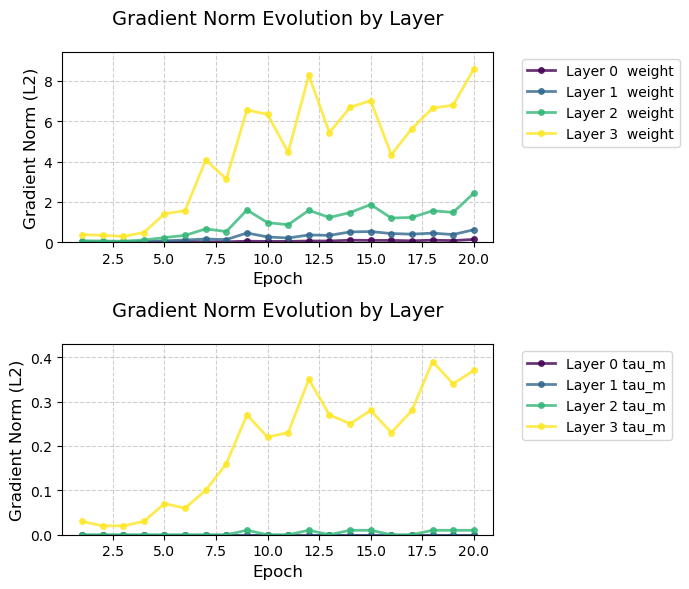

In [51]:
plt.figure(figsize=(7, 6))
plt.subplot(211)
plot_gradient_evolution(snn.test_gradients, 'linear.')
plt.subplot(212)
plot_gradient_evolution(snn.test_gradients, 'tau_m')

In [ ]:
structure = (64, 5, 'r')
extra_kwargs = {}

snn = SNN(dataset_dict=dataset_dict, structure=structure, tau_m='normal', win=50, loss_fn='mem_sum', batch_size=batch_size, device=device, 
          **extra_kwargs)

snn.set_layers()
snn.to(device)

snn.save_gradients = True

tau_lr = 0.1

print(snn)
train(snn, train_loader, test_loader, lr, num_epochs, lr_tau=tau_lr, 
      test_behavior=tb_minimal, scheduler=(10, 0.95), test_every=1, gradient_clipping = True)

Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
SNN(
  (criterion): CrossEntropyLoss()
  (layers): ModuleList(
    (0): RecurrentSNNLayer(
      (linear): Linear(in_features=700, out_features=64, bias=False)
      (linear_rec): Linear(in_features=64, out_features=64, bias=False)
    )
    (1-2): 2 x RecurrentSNNLayer(
      (linear): Linear(in_features=64, out_features=64, bias=False)
      (linear_rec): Linear(in_features=64, out_features=64, bias=False)
    )
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=20, bias=False)
    )
  )
)
Epoch [1/20], learning_rates 0.001000, 0.100000


c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Step [2/7], Loss: 3.07827
Step [4/7], Loss: 3.02415
Step [6/7], Loss: 2.99653
Step [8/7], Loss: 2.98680
8156
Time elasped: 2.5168297290802
Gradient norms: {'layers.0.tau_m': 0.0, 'layers.0.linear.weight': 0.0, 'layers.0.linear_rec.weight': 0.0, 'layers.1.tau_m': 0.0, 'layers.1.linear.weight': 0.0, 'layers.1.linear_rec.weight': 0.0, 'layers.2.tau_m': 0.0, 'layers.2.linear.weight': 0.03, 'layers.2.linear_rec.weight': 0.02, 'layers.3.tau_m': 0.01, 'layers.3.linear.weight': 0.25}
2264
Test Loss: 2.9907265504201255
Avg spk_count per neuron for all 50 time-steps 414.9690812720848
Test Accuracy of the model on the test samples: 4.505

max acc: 4.5053003533568905
Epoch [2/20], learning_rates 0.001000, 0.100000
Step [2/7], Loss: 2.99197
Step [4/7], Loss: 2.96907
Step [6/7], Loss: 2.95825
Step [8/7], Loss: 2.94583
8156
Time elasped: 2.1053740978240967
Gradient norms: {'layers.0.tau_m': 0.0, 'layers.0.linear.weight': 0.0, 'layers.0.linear_rec.weight': 0.0, 'layers.1.tau_m': 0.0, 'layers.1.linear.

In [42]:
snn.test_gradients

[[0, None]]

## Recurrent

dict_values([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.01, 0.03, 0.05, 0.05, 0.03, 0.02, 0.02, 0.05, 0.04, 0.02, 0.02, 0.03, 0.03], [0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.06, 0.04, 0.08, 0.11, 0.15, 0.11, 0.07, 0.08, 0.16, 0.11, 0.08, 0.07, 0.09, 0.1], [0.03, 0.03, 0.03, 0.07, 0.08, 0.13, 0.36, 0.24, 0.42, 0.55, 0.78, 0.64, 0.41, 0.46, 0.76, 0.51, 0.38, 0.4, 0.47, 0.48], [0.25, 0.18, 0.19, 0.85, 0.81, 1.32, 3.76, 3.01, 4.85, 7.0, 8.49, 8.14, 4.85, 4.23, 6.44, 4.88, 3.54, 3.95, 5.03, 5.03]])
8.49
dict_values([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.01, 0.01, 0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], [0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.05, 0.04, 0.08, 0.1, 0.13, 0.1, 0.06, 0.07, 0.14, 0.09, 0.07, 0.06, 0.08, 0.09], [0.02, 0.02, 0.02, 0.07, 0.07, 0.14, 0.41, 0.29, 0.53, 0.68, 0.95, 0.78, 0.46, 0.51, 0.86, 0.57, 0.41, 0.47, 0.51, 0.53]])
0.95
dict_values([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0

<Axes: title={'center': 'Gradient Norm Evolution by Layer'}, xlabel='Epoch', ylabel='Gradient Norm (L2)'>

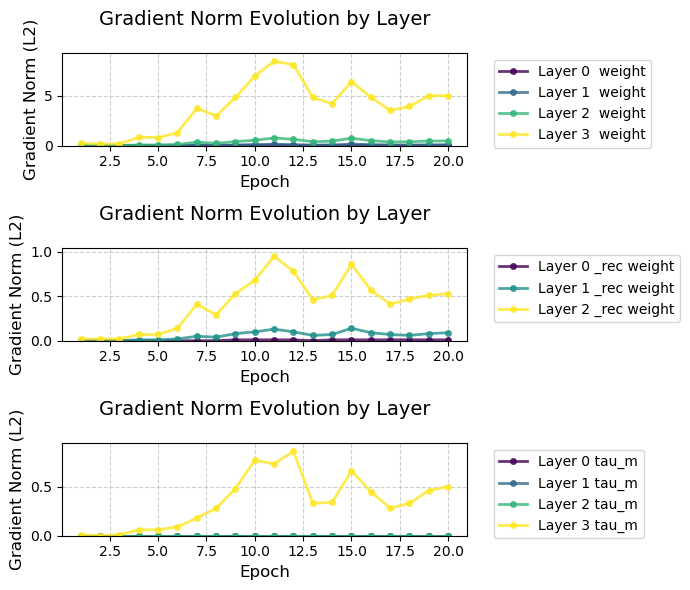

In [47]:
plt.figure(figsize=(7, 6))
plt.subplot(311)
plot_gradient_evolution(snn.test_gradients, 'linear.')
plt.subplot(312)
plot_gradient_evolution(snn.test_gradients, 'rec')
plt.subplot(313)
plot_gradient_evolution(snn.test_gradients, 'tau_m')

In [ ]:
structure = (64, 5, 'd')
extra_kwargs = {'delay_range':(40, 1),
                'pruned_delays': 3}


snn = SNN(dataset_dict=dataset_dict, structure=structure, tau_m='normal', win=50, loss_fn='mem_sum', batch_size=batch_size, device=device, 
          **extra_kwargs)

snn.save_gradients = True

snn.set_layers()
snn.to(device)
print(snn)
train(snn, train_loader, test_loader, lr, num_epochs, lr_tau=tau_lr, 
      test_behavior=tb_minimal, scheduler=(10, 0.95), test_every=1, gradient_clipping = True)

Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
SNN(
  (criterion): CrossEntropyLoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=700, out_features=64, bias=False)
    )
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=64, bias=False)
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=2560, out_features=64, bias=False)
    )
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=20, bias=False)
    )
  )
)
Epoch [1/20], learning_rates 0.001000, 0.100000


c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Step [2/7], Loss: 3.36716
Step [4/7], Loss: 2.98437
Step [6/7], Loss: 2.98082
Step [8/7], Loss: 2.91044
8156
Time elasped: 2.7687838077545166
Gradient norms: {'layers.0.tau_m': 0.0, 'layers.0.linear.weight': 0.01, 'layers.1.tau_m': 0.0, 'layers.1.linear.weight': 0.02, 'layers.2.tau_m': 0.0, 'layers.2.linear.weight': 0.15, 'layers.3.tau_m': 0.01, 'layers.3.linear.weight': 0.29}
2264
Test Loss: 2.864572763442993
Avg spk_count per neuron for all 50 time-steps 208.2944640753828
Test Accuracy of the model on the test samples: 15.945

max acc: 15.945229681978798
Epoch [2/20], learning_rates 0.001000, 0.100000
Step [2/7], Loss: 2.86551
Step [4/7], Loss: 2.80841
Step [6/7], Loss: 2.69132
Step [8/7], Loss: 2.65046
8156
Time elasped: 2.3793675899505615
Gradient norms: {'layers.0.tau_m': 0.0, 'layers.0.linear.weight': 0.01, 'layers.1.tau_m': 0.0, 'layers.1.linear.weight': 0.03, 'layers.2.tau_m': 0.0, 'layers.2.linear.weight': 0.17, 'layers.3.tau_m': 0.04, 'layers.3.linear.weight': 0.57}
2264
Test

## Delays

dict_values([[0.01, 0.01, 0.01, 0.08, 0.09, 0.05, 0.05, 0.05, 0.06, 0.04, 0.09, 0.03, 0.05, 0.04, 0.02, 0.04, 0.03, 0.04, 0.03, 0.02], [0.02, 0.03, 0.04, 0.2, 0.22, 0.21, 0.14, 0.15, 0.14, 0.13, 0.22, 0.1, 0.15, 0.12, 0.07, 0.11, 0.1, 0.13, 0.07, 0.07], [0.15, 0.17, 0.3, 0.65, 0.71, 0.84, 0.52, 0.61, 0.44, 0.48, 0.53, 0.23, 0.36, 0.29, 0.3, 0.34, 0.29, 0.25, 0.22, 0.19], [0.29, 0.57, 1.09, 2.24, 3.41, 4.04, 2.57, 2.82, 2.41, 1.97, 2.42, 1.32, 1.77, 1.68, 1.53, 1.63, 1.8, 0.94, 1.31, 0.93]])
4.04
dict_values([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.01, 0.04, 0.07, 0.13, 0.25, 0.34, 0.21, 0.25, 0.17, 0.14, 0.16, 0.1, 0.14, 0.14, 0.13, 0.12, 0.17, 0.08, 0.11, 0.08]])
0.34


<Axes: title={'center': 'Gradient Norm Evolution by Layer'}, xlabel='Epoch', ylabel='Gradient Norm (L2)'>

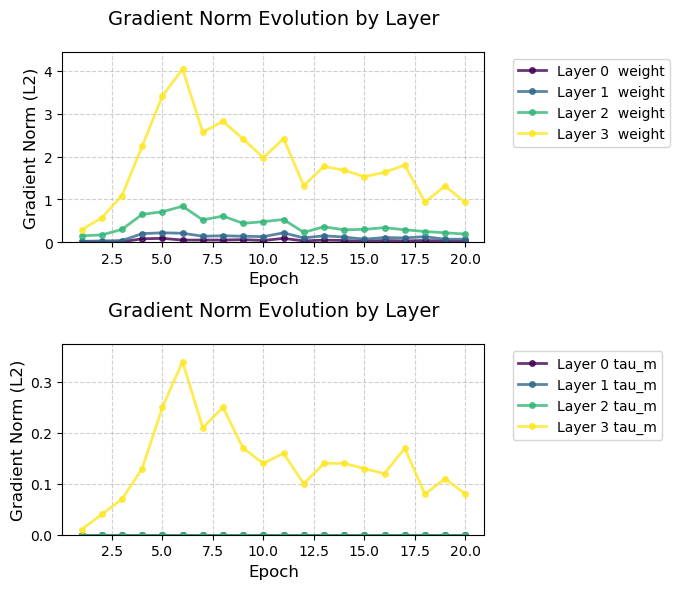

In [ ]:
plt.figure(figsize=(7, 6))
plt.subplot(211)
plot_gradient_evolution(snn.test_gradients)
plt.subplot(212)
train(snn, train_loader, test_loader, lr, num_epochs, lr_tau=tau_lr, 
      test_behavior=tb_minimal, scheduler=(10, 0.95), test_every=1, gradient_clipping = True)